In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Random number generator
rng = np.random.default_rng()
import os
import sys
import glob
import utils

sys.path.append('/home/maxf/projects/REFORM/src/grasp/data_handling/')
import prepare_obsdata_for_aspire as profa 

In [3]:
les_dir = "/home/maxf/projects/REFORM/grasp/llj_meso/nudge_meso/aspire-plugin/LLJ_climatology/sim_data/control/LLJ_ctrl_20200404"
ds_les = xr.open_dataset(f"{les_dir}/graspOutTFMetmast.001.nc")
ds_les = ds_les.rename({"height_above_ground_level":"zf"})
ds_les = ds_les.mean(dim='index')

In [4]:
data_dir = "/home/maxf/projects/da4gs/esmda/data/esmda_fields/ESMDA_ne15_a4_lidar"

In [5]:
def load_assimilation_step(step, data_dir, data='data'):
    
    if data=='data':
        if step=='posterior':
            print("Loading data posterior")
            dirs = sorted(glob.glob(f"{data_dir}/data_posterior_step*_member*.nc"))
        else:
            print(f"Loading data at step {step}")
            dirs = sorted(glob.glob(f"{data_dir}/data_prior_step{str(step).zfill(2)}_member*.nc"))
    elif data=='model':
        print(f"Loading model at step {step}")
        dirs = sorted(glob.glob(f"{data_dir}/model_post_step{str(step).zfill(2)}_member*.nc"))       
    
    ds_all = xr.Dataset()
    for i,dir in enumerate(dirs):
        ds = xr.open_dataset(dir)
        # Round time to minutes
        if data=='data':
            ds['time'] = ds['time'].dt.round('min')
            ds_all[f'u_memb{i}'] = ds['u_predobs']
            ds_all[f'v_memb{i}'] = ds['v_predobs']
        else:
            ds_all[f'u_memb{i}'] = ds['u']
            ds_all[f'v_memb{i}'] = ds['v']
    
    return ds_all

In [6]:
def compute_ens_mean(ds):
    u_mean, v_mean, M_mean = 0, 0, 0
    idx_x, idx_y, idx_M = 0, 0, 0
    
    for i, var in enumerate(ds.data_vars):
        da = ds[var]
        if 'time' in ds.sizes:
            da['time'] = da['time'].dt.round('min')
        if 'u' in var:
            u_mean += da
            idx_x += 1
        elif 'v' in var:
            v_mean += da
            idx_y += 1
        elif 'M' in var:
            M_mean += da
            idx_M += 1
        else:
            print(f"Different DataArray {var}")
    
    assert idx_x == idx_y, "Not same amount of u and v variables"
    assert idx_x != 0, "DataSet contains no variables u or v!"
    u_mean /= idx_x
    v_mean /= idx_y

    if idx_M != 0:
        M_mean /= idx_M
    
    ds_mean = xr.Dataset({
        'u_mean': u_mean,
        'v_mean': v_mean,
        'M_mean': M_mean,
        })
    return ds_mean

In [7]:
def calc_wind_mag(ds):
    ne = len(list(ds.data_vars)) // 2 
    assert len(list(ds.data_vars)) % 2 == 0, "Weird number of data-arrays, check input ds"
    for i in range(ne):
        ds[f'M_memb{i}'] = np.sqrt(ds[f'u_memb{i}']**2 + ds[f'v_memb{i}']**2)
    return ds


In [11]:
##------------------------------------------------------
## Load observtions
##-----------

BASE_DIR     = "/home/maxf/projects/da4gs/esmda"
dir_base_sim = f"{BASE_DIR}/runs/base_run/2020/04/04/00"
obs_save_dir = f"{BASE_DIR}/data/observation/synthetic_obs"
# ds_synth_obs = xr.open_dataset(f"{obs_save_dir}/ds_obs_synthetic.nc")
# grasp_levels = ds_synth_obs.zf.values
grasp_levels = np.asarray([ 16.,  48.153847,  80.61688 , 113.39207, 146.4824,179.89095 , 213.62071 , 247.67484 , 282.0564  ])
ds_restart_base = xr.open_dataset(f'{dir_base_sim}/graspOutRestart.000.nc')


## Load LiDAR data and interpolate dataset to grasp-meso levels
ds_lidar = profa.load_cbw_lidar_data(date_init='20200404', date_end='20200405')
ds_lidar = ds_lidar.sel(time=slice(f"2020-04-04T20:00:10.000000000", f"2020-04-05T02:00:00.000000000"))
ds_lidar = ds_lidar.interp(level=grasp_levels, method='linear',)
ds_lidar = ds_lidar.rename({'level': 'zf', 'ucbw': 'u', 'vcbw': 'v'})


Load cabauw data from 2020 04 to 2020 04


In [12]:
# Process data assiimilation data
ds_prior     = load_assimilation_step(step=0, data_dir=data_dir)
ds_posterior = load_assimilation_step(step='posterior', data_dir=data_dir)
ds_prior     = calc_wind_mag(ds=ds_prior)
ds_posterior = calc_wind_mag(ds=ds_posterior)
ds_prior_mean     = compute_ens_mean(ds_prior)
ds_posterior_mean = compute_ens_mean(ds_posterior)


# Process data assiimilation model
ds_model_step0 = load_assimilation_step(step=0, data_dir=data_dir, data='model')
ds_model_post  = load_assimilation_step(step=3, data_dir=data_dir, data='model')
ds_model_prior_mean = compute_ens_mean(ds_model_step0)
ds_model_post_mean  = compute_ens_mean(ds_model_post)

Loading data at step 0
Loading data posterior
Loading model at step 0
Loading model at step 3


Text(0.5, 1.0, '')

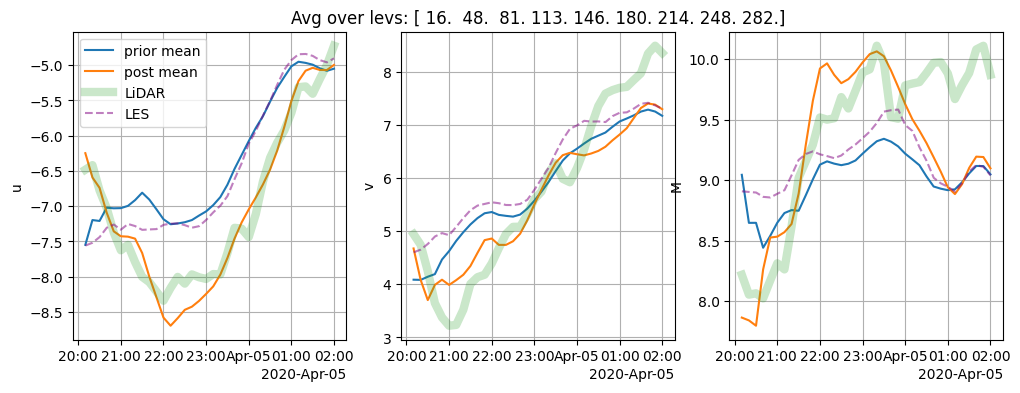

In [13]:
fig,ax = plt.subplots(ncols=3, figsize=(12,4), sharey=False)
zf_vals = ds_prior_mean.zf.values

ds_prior_mean['u_mean'].mean(dim='zf').plot(label='prior mean', ax=ax[0])
ds_posterior_mean['u_mean'].mean(dim='zf').plot(label='post mean', ax=ax[0])
ds_lidar['u'].mean(dim='zf').plot(label='LiDAR', linewidth=6,alpha=0.25, ax=ax[0])
ds_les['u'].isel(time=slice(48,84)).sel(zf=zf_vals, method='nearest').mean(dim='zf').plot(label="LES", alpha=0.5, color='purple', linestyle='--', ax=ax[0])

ax[0].legend()


ds_prior_mean['v_mean'].mean(dim='zf').plot(label='prior mean', ax=ax[1])
ds_posterior_mean['v_mean'].mean(dim='zf').plot(label='post mean', ax=ax[1])
ds_lidar['v'].mean(dim='zf').plot(label='LiDAR', linewidth=6,alpha=0.25, ax=ax[1])
ds_les['v'].isel(time=slice(48,84)).sel(zf=zf_vals, method='nearest').mean(dim='zf').plot(label="LES", alpha=0.5, color='purple', linestyle='--', ax=ax[1])



ds_prior_mean['M_mean'].mean(dim='zf').plot(label='prior mean', ax=ax[2])
ds_posterior_mean['M_mean'].mean(dim='zf').plot(label='post mean', ax=ax[2])
ds_lidar['F'].mean(dim='zf').plot(label='LiDAR', linewidth=6,alpha=0.25, ax=ax[2])

ds_les['M'].isel(time=slice(48,84)).sel(zf=zf_vals, method='nearest').mean(dim='zf').plot(label="LES", alpha=0.5, color='purple', linestyle='--', ax=ax[2])
# ax[2].legend()


for i in range(3):
    ax[i].grid()
    ax[i].set_xlabel(" ")

ax[0].set_title("")
ax[1].set_title(f"Avg over levs: {np.round(zf_vals)}")
ax[2].set_title("")

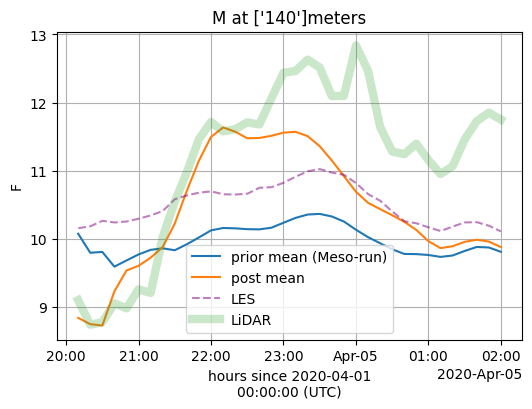

In [14]:
fig,ax = plt.subplots(ncols=1, figsize=(6,4))
ax=[ax]

levs = ['140',]

for lev in levs:

    ds_prior_mean['M_mean'].sel(zf=lev, method='nearest').plot(label='prior mean (Meso-run)', ax=ax[0])
    ds_posterior_mean['M_mean'].sel(zf=lev, method='nearest').plot(label='post mean', ax=ax[0])
    ds_les['M'].sel(zf=lev, method='nearest').isel(time=slice(48,84)).plot(label="LES", alpha=0.5, color='purple', linestyle='--',ax=ax[0])
    ds_lidar['F'].sel(zf=lev, method='nearest').plot(label='LiDAR', linewidth=6,alpha=0.25, ax=ax[0])

ax[0].legend()


ax[0].set_title(f"M at {levs}meters")

plt.grid()




In [15]:
def plot_ens_spread(ds, variable, color='grey', lw=1, alpha=0.8):
    for var in ds.data_vars:
        if variable in var:
            ds[var].mean(dim='zf').plot(color=color, linewidth=lw, alpha=alpha)

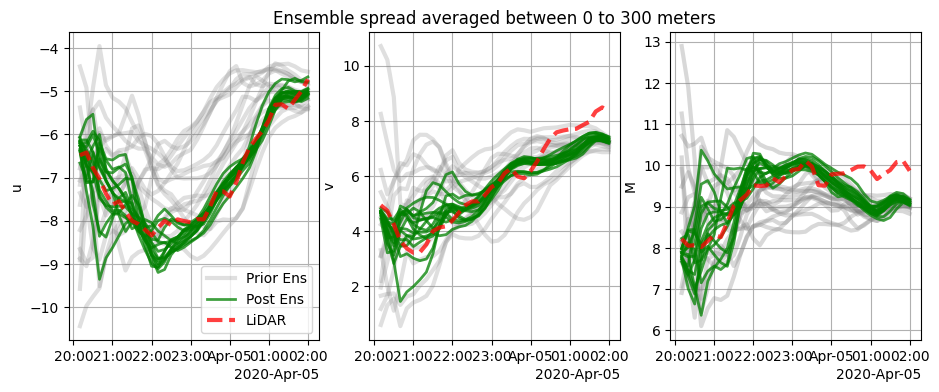

In [16]:
fig,ax = plt.subplots(ncols=3, figsize=(11,4))

for i, var in enumerate(ds_prior.data_vars):
    if 'u' in var:
        if i == 0:
            ds_prior[var].mean(dim='zf').plot(color='grey', linewidth=3, alpha=0.25, ax=ax[0], label='Prior Ens')
        else:
            ds_prior[var].mean(dim='zf').plot(color='grey', linewidth=3, alpha=0.25, ax=ax[0])
for i, var in enumerate(ds_prior.data_vars):
    if 'u' in var:
        if i == 0:
            ds_posterior[var].mean(dim='zf').plot(color='green', linewidth=2, alpha=0.75, ax=ax[0], label='Post Ens')
        else:
            ds_posterior[var].mean(dim='zf').plot(color='green', linewidth=2, alpha=0.75, ax=ax[0])

ds_lidar['u'].mean(dim='zf').plot(label='LiDAR', linestyle='--', ax=ax[0], c='red', linewidth=3, alpha=.75,)
ax[0].legend()



for var in ds_prior.data_vars:
    if 'v' in var:
        ds_prior[var].mean(dim='zf').plot(color='grey', linewidth=3, alpha=0.25, ax=ax[1])

for var in ds_prior.data_vars:
    if 'v' in var:
        ds_posterior[var].mean(dim='zf').plot(color='green', linewidth=2, alpha=0.75, ax=ax[1])
ds_lidar['v'].mean(dim='zf').plot(label='LiDAR', linestyle='--', ax=ax[1], c='red', linewidth=3, alpha=.75)


ax[1].set_title("Ensemble spread averaged between 0 to 300 meters")





for i, var in enumerate(ds_prior.data_vars):
    if 'M' in var:
        ds_prior[var].mean(dim='zf').plot(color='grey', linewidth=3, alpha=0.3, ax=ax[2])
for i, var in enumerate(ds_prior.data_vars):
    if 'M' in var:
        ds_posterior[var].mean(dim='zf').plot(color='green', linewidth=2, alpha=0.75, ax=ax[2])

ds_lidar['F'].mean(dim='zf').plot(label='LiDAR', linestyle='--', ax=ax[2], c='red', linewidth=3, alpha=.75,)

ax[2].set_ylabel("M")


for i in range(3):
    ax[i].set_xlabel("")
    ax[i].grid()


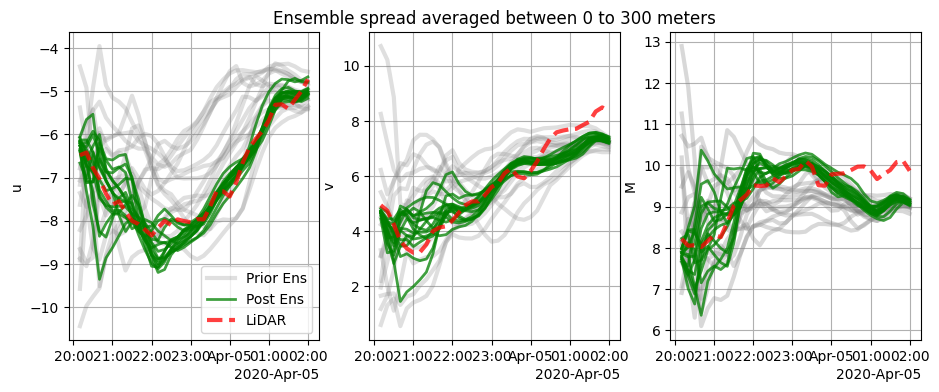

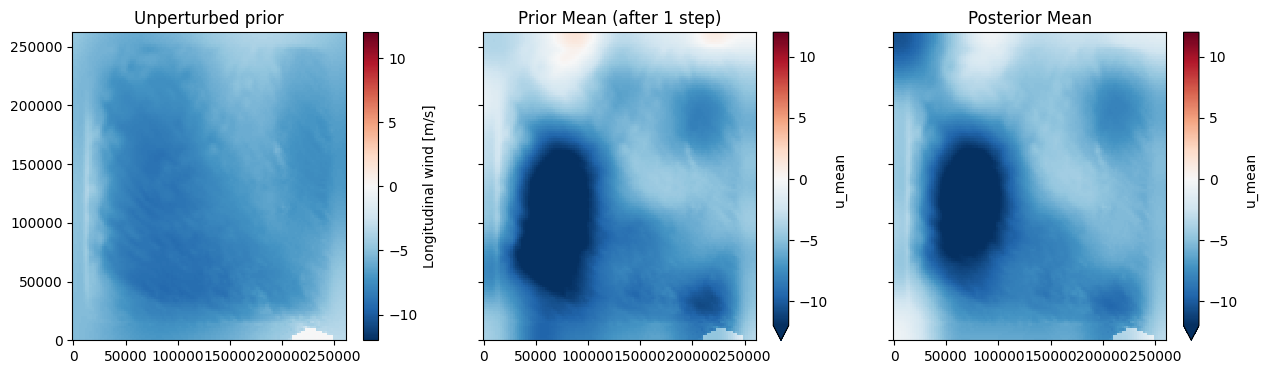

In [137]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4), sharey=True)


vmax=12
ds_restart_base['u'].isel(zf=5).plot(ax=ax[0], vmax=vmax)
ds_model_prior_mean['u_mean'].isel(zf=5).plot(ax=ax[1], vmax=vmax)
ds_model_post_mean['u_mean'].isel(zf=5).plot(ax=ax[2], vmax=vmax)


ax[0].set_title("Unperturbed prior")
ax[1].set_title("Prior Mean (after 1 step)")
ax[2].set_title("Posterior Mean")

for i in range(3):
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

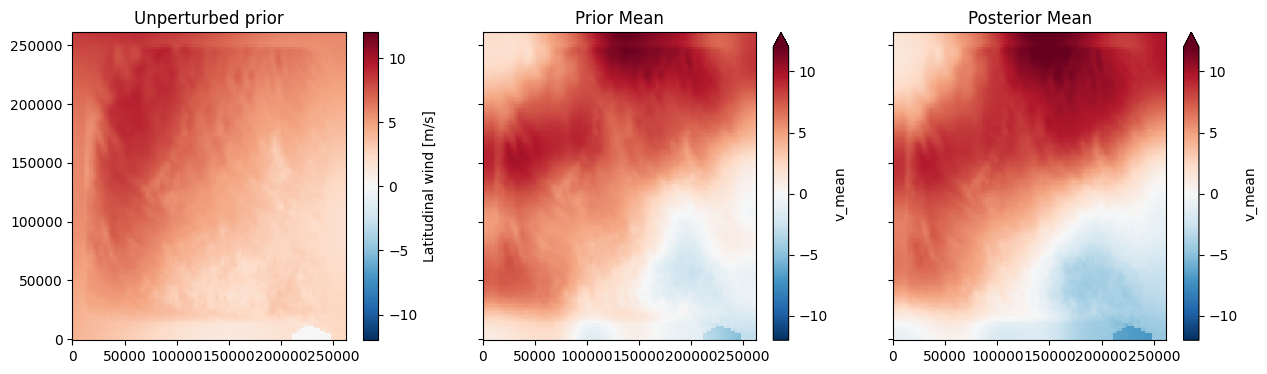

In [136]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4), sharey=True)


vmax=12
ds_restart_base['v'].isel(zf=5).plot(ax=ax[0], vmax=vmax)
ds_model_prior_mean['v_mean'].isel(zf=5).plot(ax=ax[1], vmax=vmax)
ds_model_post_mean['v_mean'].isel(zf=5).plot(ax=ax[2], vmax=vmax)


ax[0].set_title("Unperturbed prior")
ax[1].set_title("Prior Mean (after 1 step)")
ax[2].set_title("Posterior Mean")

for i in range(3):
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")